# Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста

# Описание проекта

**Задачи проекта**
- Приоритизация  гипотез, для выбора гипотезы, которую следует проверить в первую очередь. 
- Анализ результатов A/B теста:
    - Анализ кумулятивной выручки и среднего чека по группам (A-контрольная, B-тестовая)
    - Анализ относительного изменения кумулятивного  среднего чека и кумулятивного среднего количества заказов на посетителя по группам
    - Анализ аномалий и оценка их влияния на результаты A/B теста
    - Проверка статистических гипотез о равенстве среднего количества заказов на посетителя между группами и равенстве среднего чека заказа между группами критерием Манна-Уитни

**Цель проекта**

Вывод об эффективности изменений тестовой группы относительно контрольной


**Структура проекта**
- [Приоритизация гипотез;](#hypothesis)  
- [Предобработка данных;](#preprocessing)
- [Анализ A/B-теста;](#A/B-test)
- [Анализ выбросов;](#emissions)
- [Оценка влияния аномалий на результаты A/B теста;](#analysis)
- [Выводы и предположения](#results)

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import scipy.stats as stats
import datetime as dt

## Приоритизация гипотез 
<a id='hypothesis'></a>

В нашем распоряжении 9 гипотез для увеличения выручки интернет-магазина и 4 компоненты, оцененные по 10-бальной шкале (Reach,Impact,Confidence и Efforts). Для приоритезации гипотез будем использовать фреймворки ICE и RICE.

Файл `/datasets/hypothesis.csv`
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [2]:
pd.set_option('display.max_colwidth', None)
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### ICE

Рассчитаем фреймворк ICE и отсортируем таблицу с гипотезами по убыванию значения ICE.

In [3]:
hypothesis['ice_score'] = round(((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']),2)
hypothesis.sort_values('ice_score',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Лидируют 3 гипотезы:
- `Запустить акцию, дающую скидку на товар в день рождения`. 

- `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`, 

- `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`

У гипотез высокие показатели Impact и Confidence их стоит проверить в первую очередь, так как они имеют высокую значимость для продукта.

### RICE

Расчитаем фреймворк RICE.

In [4]:
hypothesis['rice_score'] = round((hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],2)
hypothesis.sort_values('rice_score',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По результатам расчета RICE лидируют 2 гипотезы: 
- `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` 
- `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`. 

Данные задачи повлияют на большое количество пользователей, за счет параметра Reach, их RISE выше остальных.

Гипотезы:  `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`	и `Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию` разделили 3 и 4 место. 

___
**Вывод**

 - Приоритизация гипотез при применении RICE вместо ICE изменилась за счет учета параметра Reach, показывающего скольких пользователей затронет изменение. На первое место по приоритету вышли задачи, затрагивающие большее количество пользователей. 
 - Далее будем тестировать гипотезу о том, что добавление формы подписки на все основные страницы увеличит количество заказов и средний чек 
___

## Анализ A/B-теста 
<a id='A/B-test'></a>

**Описание данных**

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv` 
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [5]:
orders = pd.read_csv('orders.csv')
#orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(orders.head())
visitors = pd.read_csv('visitors.csv')
#visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Предобработка данных  
<a id='preprocessing'></a>

Проверим наличие дубликатов и пропусков в данных, а так посмотрим общую информацию о файлах. 

In [6]:
display('Дубликатов в файле:',orders.duplicated().sum())
display('Пропусков в данных:',orders.isna().sum())
display(orders.info())

'Дубликатов в файле:'

0

'Пропусков в данных:'

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

In [7]:
display('Дубликатов в файле:',visitors.duplicated().sum())
display('Пропусков в данных:',visitors.isna().sum())
display(visitors.info())

'Дубликатов в файле:'

0

'Пропусков в данных:'

date        0
group       0
visitors    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Дубликаты и пропуски в данных не обнаружены. Тип данных в столбцах с датами `object`. Приведем их к типу `datetime`

In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(orders['date'].dtype)
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(visitors['date'].dtype)

dtype('<M8[ns]')

dtype('<M8[ns]')

Теперь типы данных соответствуют заявленным

#### Функции для построения графиков

In [9]:
# Функция для графиков кумулятивных данных по группам и графиков относительного изменения кумулятивных данных
def chart_AB (type_chart,parameter,title,ylabel):
    if type_chart == 'AB':
        xa = cumulativeData.query('group == "A"')['date']
        ya = cumulativeData.query('group == "A"')[parameter]
        xb = cumulativeData.query('group == "B"')['date']
        yb = cumulativeData.query('group == "B"')[parameter]
        plt.figure(figsize=(20,8))
        plt.plot(xa,ya,'o-',color='g',label = 'A')
        plt.plot(xb,yb,'o-',label='B')
        plt.grid()
        plt.legend()
        plt.xlabel("Дата")
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.title(title)
        #plt.axis(scale)
        plt.show()
    elif type_chart == 'relative':
        xa = cumulativeData.query('group == "A"')['date']
        xb = cumulativeData.query('group == "B"')['date']
        average_bill_B = (cumulativeData.query('group == "B"')[parameter]).reset_index(drop=True)
        average_bill_A = cumulativeData.query('group == "A"')[parameter].reset_index(drop=True)
        average_bill = average_bill_B/average_bill_A-1
        plt.figure(figsize=(20,8))
        plt.plot(xa,average_bill,'o-',color='r',label = 'A')
        plt.grid()
        plt.xlabel("Дата")
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.title(title)
        plt.axhline(y=0, color='black', linestyle='--') 
        plt.show()        
        

### Кумулятивная выручка по группам

Рассчитаем кумулятивную выручку и кумулятивное количество посетителей интернет-магазина по группам A И B и построим график кумулятивной выручки по группам.

In [10]:
#создадим массив уникальных пар дат и групп
date_group = orders[['date','group']].drop_duplicates()


#считаем кумулятивные данные выручки по группам
revenue_grupp = date_group.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'],
                                                                 orders['group']==x['group'])]\
                                 .agg({'date':'max',
                                       'group':'max',
                                       'transactionId':'nunique',
                                       'visitorId':'nunique',
                                       'revenue':'sum'}),
                                axis = 1).sort_values(by=['date','group'])
revenue_grupp.columns = ['date','group','orders','buyers','sum_revenue']

# получаем агрегированные кумулятивные данные по дням  о посетителях интернет-магазина 
visitor_grupp = date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                   visitors['group'] == x['group'])]\
                                 .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                                 axis=1).sort_values(by=['date','group'])
visitor_grupp.columns = ['date','group','sum_visitors']

# объединяем кумулятивные данные в одной таблице 
cumulativeData = revenue_grupp.merge(visitor_grupp, left_on=['date', 'group'], right_on=['date', 'group'])


cumulativeData.head()

,date,group,orders,buyers,sum_revenue,sum_visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Проверим корректно ли был собран датафрейм с кумулятивными данными. Из начальных данных известно, что A/B тест проводился с 1.08.2019 по 31.08.2019, соответственно датафрейм должен иметь 62 строки для данных каждой из групп. Так же проверим наличие пропусков.

In [11]:
display('Строк в датафрейме: ',cumulativeData.shape[0])
display('Пропуски:',cumulativeData.isna().sum())
display('Минимальная дата:',cumulativeData['date'].min(),'Максимальная дата:',cumulativeData['date'].max())

'Строк в датафрейме: '

62

'Пропуски:'

date            0
group           0
orders          0
buyers          0
sum_revenue     0
sum_visitors    0
dtype: int64

'Минимальная дата:'

Timestamp('2019-08-01 00:00:00')

'Максимальная дата:'

Timestamp('2019-08-31 00:00:00')

Датафрейм собран корректно.
Теперь построим график кумулятивной выруски по группам

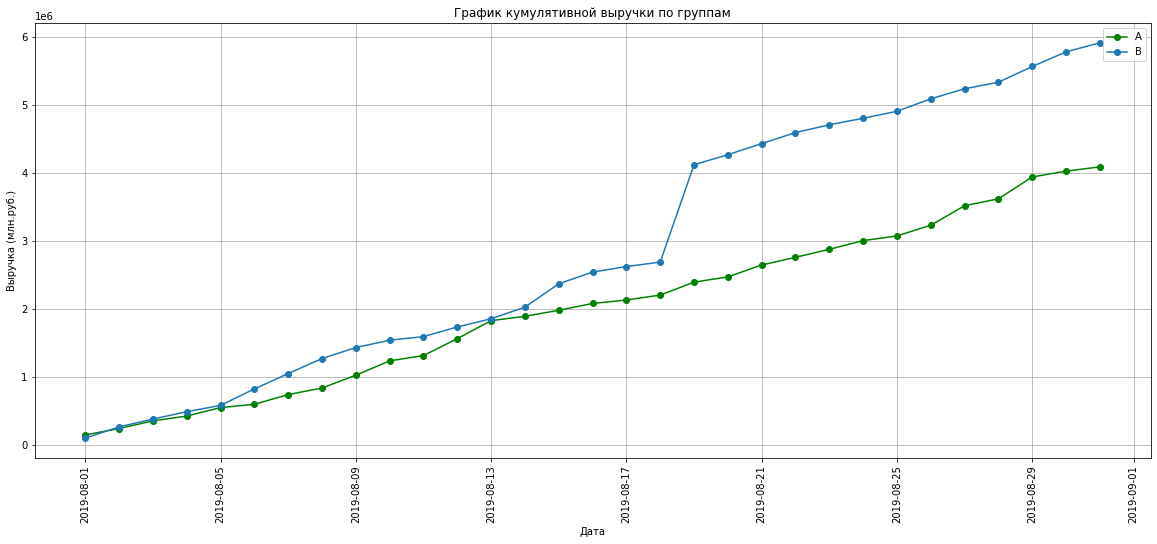

In [12]:
chart_AB('AB','sum_revenue','График кумулятивной выручки по группам','Выручка (млн.руб.)')

___
**Вывод**
*	По графику видно, что группа выручка группы B больше, чем у контрольной группы.
* На 19-й день теста (19 августа) наблюдается резкий скачок и значения выручки группы B сильно отрывается от контрольной группы. Связано ли это с изменениями в продукте или с аномально дорогим заказом стоит выяснить. 

___

### Кумулятивный средний чек по группам
Построим график кумулятивного среднего чека по группам. 

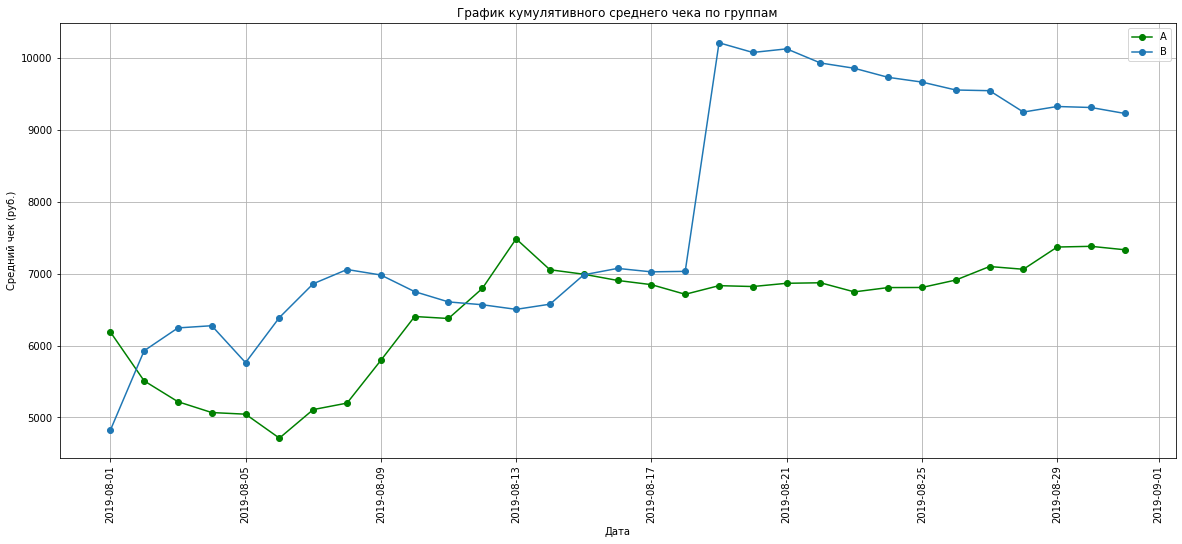

In [13]:
# Рассчет среднего чека
cumulativeData['average_bill'] = round(cumulativeData['sum_revenue']/cumulativeData['orders'],2)

chart_AB('AB','average_bill',
        'График кумулятивного среднего чека по группам',
        'Средний чек (руб.)')

___
**Вывод**
* Кумулятивное значение среднего чека по группам не стабильно. 
* Так же наблюдается скачок значений группы B на 19-й день теста
* Принимать решение по данной метрике рано, следует проанализировать аномально высокие значения. 
___

### Относительное изменение кумулятивного среднего чека группы B к группе A
Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

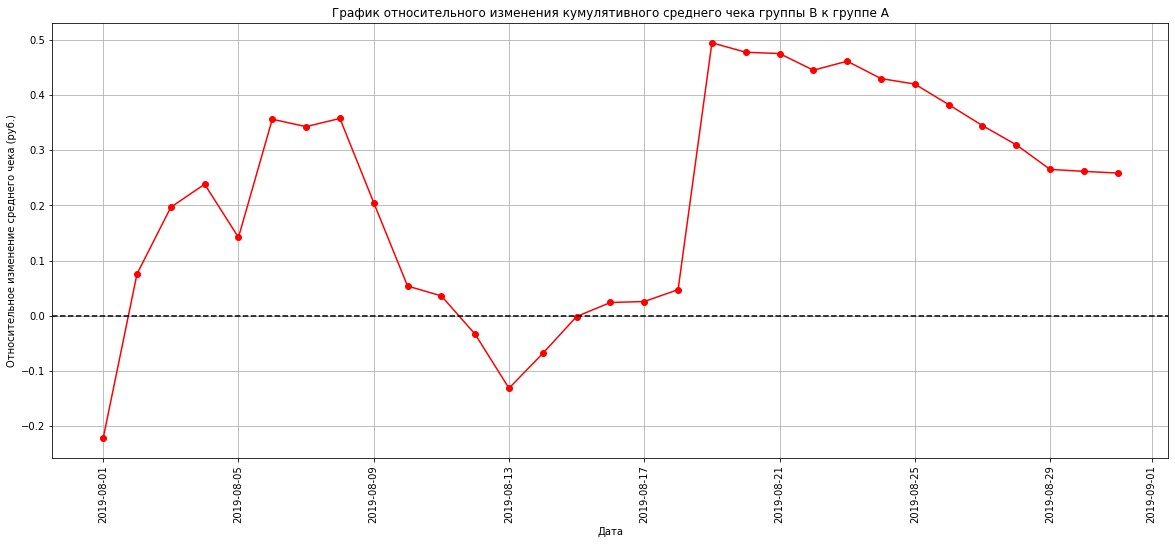

In [14]:
chart_AB('relative','average_bill',
         'График относительного изменения кумулятивного среднего чека группы B к группе A',
         'Относительное изменение среднего чека (руб.)')

____
**Вывод**
* Наблюдаются резкие изменения среднего чека в несколько дат: 6.08 и  19.08 

* К 19-му дню теста прирост среднего чека группы   50%, а к концу теста значение снижается, это явно влияние аномально дорогих заказов.
____

### Кумулятивное среднее количество заказов на посетителя по группам
Построим график кумулятивного среднего количества заказов на посетителя по группам. 

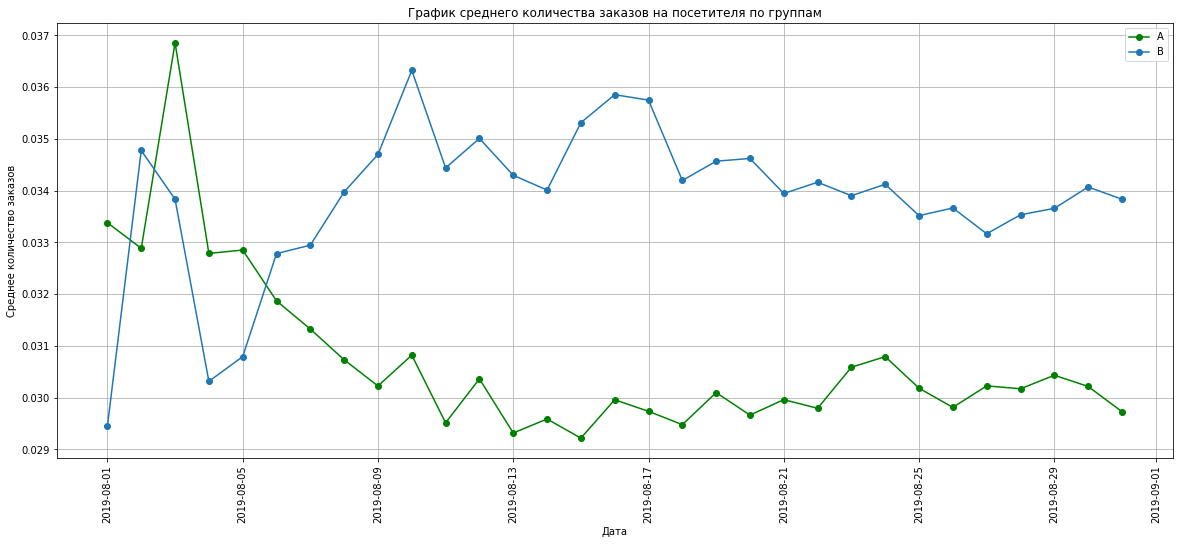

In [15]:
# расчитаем количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['sum_visitors']

chart_AB('AB','conversion',
        'График среднего количества заказов на посетителя по группам',
        'Среднее количество заказов')


___
**Вывод**
* С 6-го дня теста наблюдается повышение среднего количества заказов в тестовой группе B
* Наблюдаются отдельные пики на 10-й день и с 15-го по 17-й, что может быть связано с аномально высоким количеством заказов некоторых пользователей
* В целом к концу теста наблюдается превышение значений среднего количества заказов у группы B и устойчивое колебание около одного значения.
___

### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A
* Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

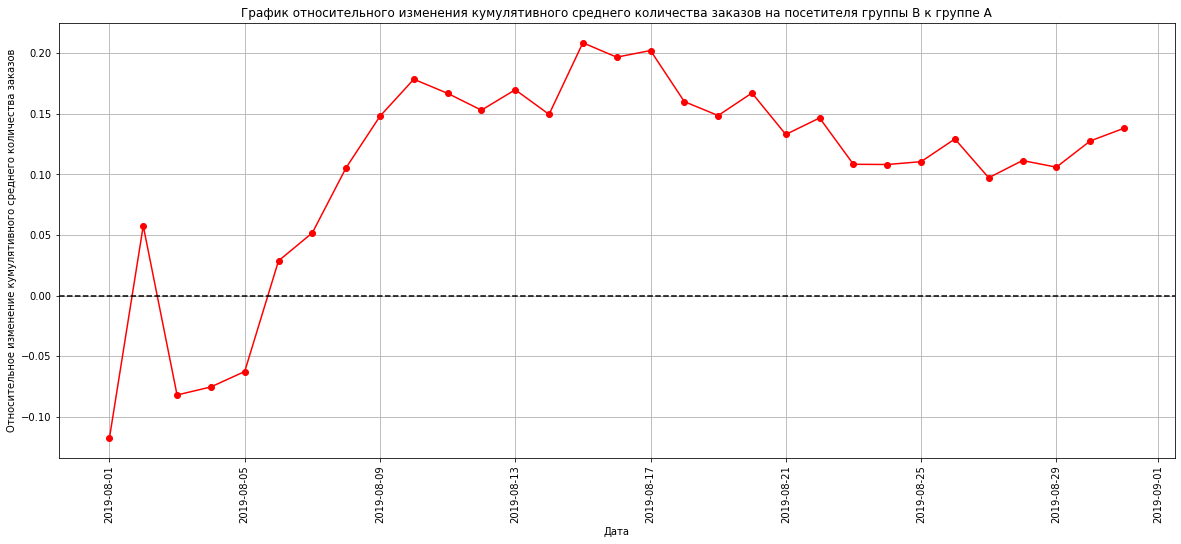

In [16]:
chart_AB('relative','conversion',
        'График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A',
        'Относительное изменение кумулятивного среднего количества заказов')

___
**Вывод**
* По графику видно, что группа B лидирует по метрике начиная с 6-го дня проведения теста
* К концу месяца значения зафиксировались около 10-15% прироста 
___

___
**Предварительные выводы**
* Тестовая группа B лидирует по количеству заказов, можно сказать, что после изменения в продукте пользователи стали более охотно покупать либо это влияние пользователей сделавших аномально большое количество заказов
* По среднему чеку так же наблюдается явное влияние выбросов в виде очень дорогих заказов. Сделать предварительные выводы сложно, нужно исследовать аномальные значения 

___

## Анализ выбросов 
<a id='emissions'></a>

В предыдущих пунктах исследования было выявлено, что на метрики могут влиять пользователи с аномально большим количеством заказов и очень дорогие заказы. Проанализируем количество заказов по пользователям и стоимости заказов.

### Количество заказов по пользователям

Построим гистограмму и  точечный график количества заказов по пользователям. 

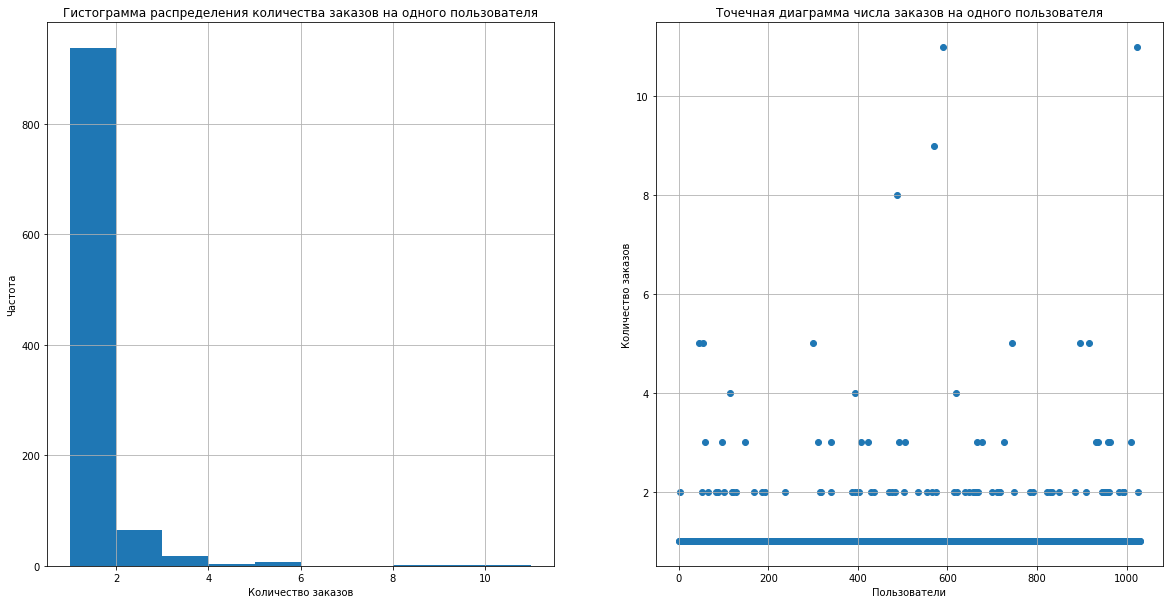

In [17]:
number_of_orders = orders.groupby('visitorId').agg({'transactionId':'count'})
x_value = pd.Series(range(0,len(number_of_orders)))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(number_of_orders['transactionId'])
plt.grid()
plt.title('Гистограмма распределения количества заказов на одного пользователя')
plt.xlabel("Количество заказов")
plt.ylabel('Частота')

plt.subplot(1,2,2)
plt.scatter(x_value, number_of_orders['transactionId']) 
plt.grid()
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.xlabel("Пользователи")
plt.ylabel('Количество заказов')
plt.show()

По графикам видно, что преимущественное большинство пользователей совершает не более одного заказа. 
На точечном графике видно, что пользователей с 2-мя заказами тоже приличное количество. Чтобы оценить, включать ли в анализ пользователей с 2 и более заказами посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [18]:
np.percentile(number_of_orders['transactionId'], [95, 99])

array([2., 4.])

___
**Вывод**

* Не более 5% пользователей совершили по 2 заказа и более, и не более 1% совершили больше 4 заказов. 
* Для анализа возьмем пользователей 1 и 2 заказами, отсеяв 5% пользователей, заказывающих больше. 
____

### Анализ стоимостей заказов

Аналогично построим графики стоимостей заказов.

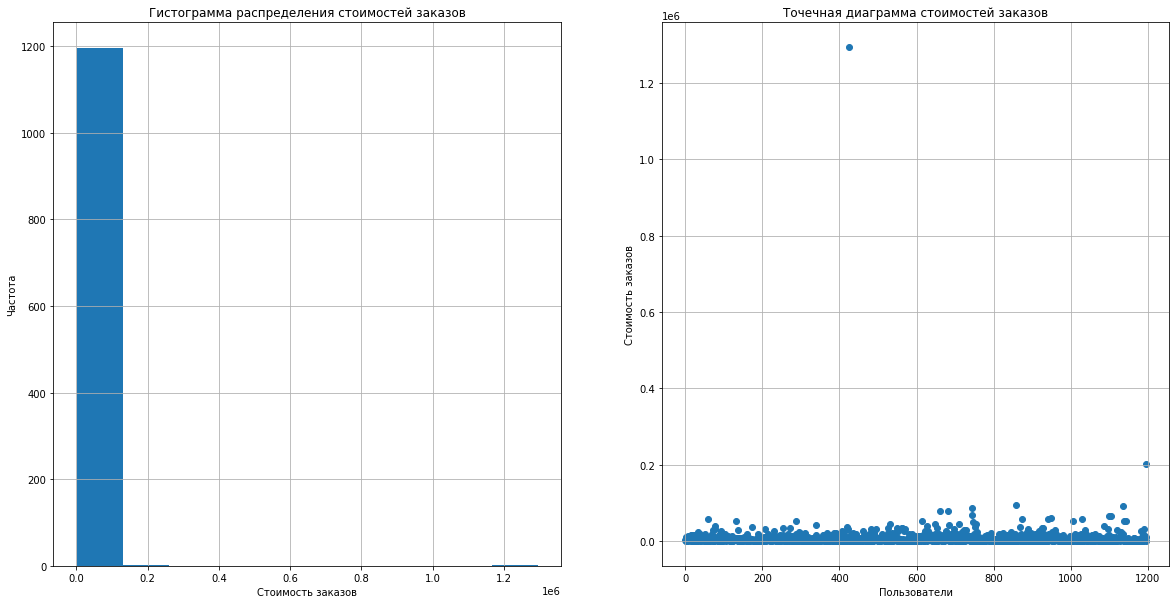

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(orders['revenue'])
plt.grid()
plt.title('Гистограмма распределения стоимостей заказов')
plt.xlabel("Стоимость заказов")
plt.ylabel('Частота')

plt.subplot(1,2,2)
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.title('Точечная диаграмма стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

Видно, что пользователей со стоимостью заказов менее 100 000 руб преобладающее количество. Изменим масштаб точечного графика для более точной оценки

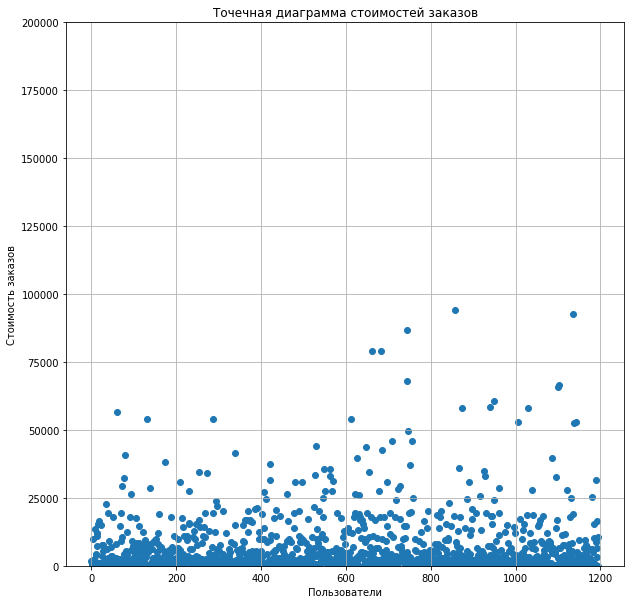

In [20]:
plt.figure(figsize=(10,10))

plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.title('Точечная диаграмма стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.ylim(0,200000)
plt.show()

Основная масса пользователей совершает покупки в пределах 25 000 руб. Посчитаем 95-й и 99-й перцентили

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

___
**Вывод**

* Не более 5% заказов превышали по стоимости 28 000 руб. Заказов дороже 58 233.2 руб в выборке не более 1 % 
* Для анализа возьмем заказы не дороже 28000 руб. 
____

## Оценка влияния аномалий на результаты A/B теста 
<a id='analysis'></a>

### «Сырые» данные
#### Различие  в среднем количестве заказов на посетителя между группами 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

В качестве `нулевой гипотезы` примем, что различий между группами A и B нет. `Альтернативная гипотеза` - есть статистически значимые различия  

In [22]:
# создадим таблицы с количеством пользователей в указанную дату для групп А и В 
visitors_dateA = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_dateA.columns = ['date', 'visitors_dateA']

visitors_dateB = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_dateB.columns = ['date', 'visitors_dateB']

# количество заказов и суммарная выручка по  датам
orders_dateA = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_dateA.columns = ['date', 'orders_dateA', 'revenue_dateA']

orders_dateB = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_dateB.columns = ['date', 'orders_dateB', 'revenue_dateB']

In [23]:
# Рассчет кумулятивных данных
# Количество пользователей до выбранной даты включительно 
visitors_cummA = visitors_dateA.apply(lambda x: visitors_dateA[visitors_dateA['date'] <= x['date']].agg({'date': 'max',
                                                                                                         'visitors_dateA': 'sum'}),axis=1,)
visitors_cummA.columns = ['date', 'visitors_cummA']


visitors_cummB = visitors_dateB.apply(lambda x: visitors_dateB[visitors_dateB['date'] <= x['date']].agg({'date': 'max',
                                                                                                         'visitors_dateB': 'sum'}),axis=1,)
visitors_cummB.columns = ['date', 'visitors_cummB']

# Суммарное количество заказов и суммарная выручка до выбранной даты

orders_cummA = orders_dateA.apply(lambda x: orders_dateA[orders_dateA['date'] <= x['date']].agg({'date': 'max',
                                                                                                 'orders_dateA': 'sum',
                                                                                                 'revenue_dateA': 'sum'}),axis=1).sort_values(by=['date'])
orders_cummA.columns = ['date','orders_cummA','revenue_cummA',]


orders_cummB = orders_dateB.apply(lambda x: orders_dateB[orders_dateB['date'] <= x['date']].agg({'date': 'max',
                                                                                                 'orders_dateB': 'sum',
                                                                                                 'revenue_dateB': 'sum'}),axis=1).sort_values(by=['date'])
orders_cummB.columns = ['date','orders_cummB','revenue_cummB']

In [24]:
#Объединение таблиц
data = (
    orders_dateA.merge(
        orders_dateB, left_on='date', right_on='date', how='left')
    .merge(orders_cummA, left_on='date', right_on='date', how='left')
    .merge(orders_cummB, left_on='date', right_on='date', how='left')
    .merge(visitors_dateA, left_on='date', right_on='date', how='left')
    .merge(visitors_dateB, left_on='date', right_on='date', how='left')
    .merge(visitors_cummA, left_on='date', right_on='date', how='left')
    .merge(visitors_cummB, left_on='date', right_on='date', how='left'))
data.head()

,date,orders_dateA,revenue_dateA,orders_dateB,revenue_dateB,orders_cummA,revenue_cummA,orders_cummB,revenue_cummB,visitors_dateA,visitors_dateB,visitors_cummA,visitors_cummB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [25]:
# Посчитаем число заказов по пользователям
orders_usersA = (orders[orders['group'] == 'A'].groupby('visitorId',
                                                        as_index=False).agg({'transactionId': pd.Series.nunique}))
orders_usersA.columns = ['userId', 'orders']

orders_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_usersB.columns = ['userId', 'orders'] 

In [26]:
# Добавим в таблицу с количеством заказов по пользователям нули, для пользователей, которые ничего не заказывали
sampleA = pd.concat([orders_usersA['orders'],
                     pd.Series(0,
                               index=np.arange(data['visitors_dateA'].sum() - len(orders_usersA['orders'])),
                               name='orders')],axis=0)

sampleB = pd.concat([orders_usersB['orders'],
                     pd.Series(0,
                               index=np.arange(data['visitors_dateB'].sum() - len(orders_usersB['orders'])),
                               name='orders')],axis=0)

In [27]:
# p-value для сравнения среднего между группами.
alpha = 0.05
p_value_raw = round(stats.mannwhitneyu(sampleA, sampleB)[1],3)

if p_value_raw < alpha:
    print(f'p_value = {p_value_raw} Отвергаем нулевую гипотезу, есть значимые различия в количестве заказов между группами') 
         
else:
    print(f'p_value = {p_value_raw} Оснований отвергнуть нулевую гипотезу нет, значимых различий в количестве заказов между группами нет ')
    
# Относительное различие в среднем между группами. 
avg_raw = round(sampleB.mean() / sampleA.mean() - 1,3)
print(f'Относительное различие в среднем между группами: {avg_raw}')

p_value = 0.017 Отвергаем нулевую гипотезу, есть значимые различия в количестве заказов между группами
Относительное различие в среднем между группами: 0.138


___
**Вывод**
* По сырым данным есть значимые различия в среднем количестве заказов между группами 
* Наблюдается относительный прирост в количестве заказов в группе B в 13,8%
___

####  Различия в среднем чеке заказа между группами по «сырым» данным
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

In [28]:
#  p-value для сравнения средних чеков между группами.
grouppA = orders[orders['group']=='A']['revenue']
grouppB = orders[orders['group']=='B']['revenue']
p_value_raw2 = round(stats.mannwhitneyu(grouppA, grouppB)[1] , 3)

if p_value_raw2 < alpha:
    print(f'p_value = {p_value_raw2} Отвергаем нулевую гипотезу, есть значимые различия в среднем чеке заказа между группами')
else:
    print(f'p_value = {p_value_raw2} Оснований отвергнуть нулевую гипотезу нет, значимых различий в среднем чеке заказа между группами нет')

# Относительный прирост среднего чека группы B
avg_raw2 = round(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1,3)
print(f'Относительный прирост среднего чека группы B: {avg_raw2}')


p_value = 0.729 Оснований отвергнуть нулевую гипотезу нет, значимых различий в среднем чеке заказа между группами нет
Относительный прирост среднего чека группы B: 0.259


___
**Вывод**
* По среднему чеку есть значимых различий между группами не наблюдается.
* При этом относительный прирост среднего чека группы B аж 25,9%, что скорее всего так же связано с очень дорогими заказами 

____

### «Очищенные» данные
#### Различие  в среднем количестве заказов на посетителя между группами 

В качестве верхней границы количества заказов было принято 2, а по стоимости заказа 28 000 руб. Посчитаем какой процент пользователей был удален из данных. 

In [29]:
users_filter_count_orders = pd.concat([orders_usersA[orders_usersA['orders'] > 2]['userId'],
                          orders_usersB[orders_usersB['orders'] > 2]['userId'],],axis=0,)
users_filter_expensive_orders = orders[orders['revenue'] > 28000]['visitorId']
abnormal_users = (pd.concat([users_filter_count_orders, users_filter_expensive_orders], axis=0).drop_duplicates().sort_values())
all_users = orders['visitorId'].nunique()
print(abnormal_users.head(5))
print(f'Доля аномальных пользователей {abnormal_users.shape[0]/all_users:.2%}')

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Доля аномальных пользователей 7.18%


Удалим из датасета 7,18% пользователей. 

In [30]:
sampleA_filter = pd.concat([orders_usersA[np.logical_not(orders_usersA['userId'].isin(abnormal_users))]['orders'],
        pd.Series(0,
                  index=np.arange(data['visitors_dateA'].sum() - len(orders_usersA['orders'])),
                  name='orders')],axis=0)

sampleB_filter = pd.concat([orders_usersB[np.logical_not(orders_usersB['userId'].isin(abnormal_users))]['orders'],
                            pd.Series(0,
                                      index=np.arange(data['visitors_dateB'].sum() - len(orders_usersB['orders'])),
                                      name='orders')],axis=0)

In [31]:
# p-value для сравнения среднего между группами.
p_value_filter = round(stats.mannwhitneyu(sampleA_filter, sampleB_filter)[1],3)

if p_value_filter < alpha:
    display(f'p_value = {p_value_filter} Отвергаем нулевую гипотезу, есть значимые различия в среднем количестве заказов между группами')
          
else:
    display(f'p_value = {p_value_filter} Оснований отвергнуть нулевую гипотезу нет, значимых различий в среднем количестве заказов между группами нет ')
    
# Относительное различие в среднем между группами. 
avg_filter = round(sampleB_filter.mean() / sampleA_filter.mean() - 1,3)
display(f'Относительное различие в среднем между группами: {avg_filter}')

'p_value = 0.013 Отвергаем нулевую гипотезу, есть значимые различия в среднем количестве заказов между группами'

'Относительное различие в среднем между группами: 0.173'

___
**Вывод**
* По среднему количеству заказов на пользователя есть значимые различия между группами A И B
* При этом относительный прирост среднего чека группы B аж 17,3%, группа B лидирует
____

#### Различия в среднем чеке заказа между группами 
Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [32]:
#  p-value для сравнения средних чеков между группами.
grouppA_filter = orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']
grouppB_filter = orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']
p_value_filter2 = round(stats.mannwhitneyu(grouppA_filter, grouppB_filter)[1] , 3)

if p_value_filter2 < alpha:
    display(f'p_value = {p_value_filter2} Отвергаем нулевую гипотезу,есть значимые различия в среднем чеке заказа между группами ')
else:
    display(f'p_value = {p_value_filter2} Оснований отвергнуть нулевую гипотезу нет,значимых различий  в среднем чеке заказа  между группами нет') 
        

# Относительный прирост среднего чека группы B
B = orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()
A = orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()
avg_filter2 = round(B/A-1,3)
                                                                                                                                     
display(f'Относительный прирост среднего чека группы B: {avg_filter2}')


'p_value = 0.738 Оснований отвергнуть нулевую гипотезу нет,значимых различий  в среднем чеке заказа  между группами нет'

'Относительный прирост среднего чека группы B: -0.02'

___
**Вывод**
* По среднему чеку значимых различий между группами нет. 
* При этом группа B даже проигрывает, наблюдается убыль на 2%
____
        

___

**Общий вывод**
* Было выявлено значительное влияние аномалий на метрики.
* По Количеству заказов было выявлено, что группа B однозначно лидирует. После "очистки" данных от выбросов процент прироста увеличился на 3,5 ед. процента и составил 17,3%
* По среднему чеку заказа после удаления аномалий выяснилось, что средний чек группы B уменьшился на 2% по отношению к контрольной группе, и значимых различий между группами не выявлено. 

___

## Выводы и предположения. 
<a id='results'></a>
* Входе A/B теста проверили гипотезу о том, что добавление формы подписки на все основные страницы увеличит количество заказов и средний чек 
* Решение по результатам теста - остановить тест, зафиксировать победу группы B. 
* Был зафиксирован рост количества заказов относительно группы A,а на средний чек проведение теста никак не повлияло, то есть пользователи продолжали в среднем столько же тратить денег на заказ, но стали заказывать больше, что приведет к росту выручки. 